# Imports

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [3]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [ ]:
%run ../vinbig.py

In [4]:
DATASET_DIR_OLD = DATASET_DIR.replace('/dataset-png', '')

# Pass numpy to png

In [4]:
from PIL import Image
from tqdm.auto import tqdm

In [6]:
images_dir = os.path.join(DATASET_DIR_OLD, 'train_np')
image_names = os.listdir(images_dir)
len(image_names)

15000

In [13]:
for image_name in tqdm(image_names):
    fpath = os.path.join(images_dir, image_name)

    arr = np.load(fpath)

    image_name = image_name.strip('.npy')
    out_fpath = os.path.join(DATASET_DIR, 'images', f'{image_name}.png')

    image = Image.fromarray(arr, mode='L')
    image.save(out_fpath)

  0%|          | 0/15000 [00:00<?, ?it/s]

# Labels df

## Load dataframe

In [18]:
from collections import defaultdict, Counter
from tqdm.auto import tqdm

In [7]:
fpath = os.path.join(DATASET_DIR_OLD, 'train.csv')
df = pd.read_csv(fpath)
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


In [8]:
len(df), len(set(df['image_id']))

(67914, 15000)

In [9]:
Counter(df['class_name'])

Counter({'No finding': 31818,
         'Cardiomegaly': 5427,
         'Aortic enlargement': 7162,
         'Pleural thickening': 4842,
         'ILD': 1000,
         'Nodule/Mass': 2580,
         'Pulmonary fibrosis': 4655,
         'Lung Opacity': 2483,
         'Atelectasis': 279,
         'Other lesion': 2203,
         'Infiltration': 1247,
         'Pleural effusion': 2476,
         'Calcification': 960,
         'Consolidation': 556,
         'Pneumothorax': 226})

## Check labels consistency

### Images with multiple diseases

In [10]:
reduced_df = df.groupby('image_id')['class_id'].apply(list)
reduced_df

image_id
000434271f63a053c4128a0ba6352c7f                               [14, 14, 14]
00053190460d56c53cc3e57321387478                               [14, 14, 14]
0005e8e3701dfb1dd93d53e2ff537b6e                            [7, 8, 6, 7, 4]
0006e0a85696f6bb578e84fafa9a5607                               [14, 14, 14]
0007d316f756b3fa0baea2ff514ce945    [13, 11, 3, 11, 13, 0, 5, 5, 0, 11, 13]
                                                     ...                   
ffe6f9fe648a7ec29a50feb92d6c15a4                            [3, 0, 9, 3, 3]
ffea246f04196af602c7dc123e5e48fc                               [14, 14, 14]
ffeffc54594debf3716d6fcd2402a99f                                  [0, 0, 0]
fff0f82159f9083f3dd1f8967fc54f6a                               [14, 14, 14]
fff2025e3c1d6970a8a6ee0404ac6940                               [14, 14, 14]
Name: class_id, Length: 15000, dtype: object

In [11]:
d = reduced_df.to_dict()
d

{'000434271f63a053c4128a0ba6352c7f': [14, 14, 14],
 '00053190460d56c53cc3e57321387478': [14, 14, 14],
 '0005e8e3701dfb1dd93d53e2ff537b6e': [7, 8, 6, 7, 4],
 '0006e0a85696f6bb578e84fafa9a5607': [14, 14, 14],
 '0007d316f756b3fa0baea2ff514ce945': [13, 11, 3, 11, 13, 0, 5, 5, 0, 11, 13],
 '000ae00eb3942d27e0b97903dd563a6e': [14, 14, 14],
 '000d68e42b71d3eac10ccc077aba07c1': [9,
  9,
  9,
  9,
  11,
  13,
  11,
  0,
  9,
  9,
  7,
  9,
  9,
  9,
  7,
  9],
 '00150343289f317a0ad5629d5b7d9ef9': [11,
  0,
  11,
  13,
  10,
  10,
  11,
  9,
  0,
  7,
  10,
  7,
  10,
  3,
  13,
  11,
  0],
 '00176f7e1b1cb835123f95960b9a9efd': [14, 14, 14],
 '001d127bad87592efe45a5c7678f8b8d': [13, 13, 2, 13, 13, 13],
 '0021df30f3fddef551eb3df4354b1d06': [14, 14, 14],
 '00291f7aff0123ea76a59998effef229': [14, 14, 14],
 '0032c6091dc8f1b1245fc2f5f45458fa': [14, 14, 14],
 '003cfe5ce5c0ec5163138eb3b740e328': [14, 14, 14],
 '0046f681f078851293c4e710c4466058': [0,
  6,
  13,
  11,
  13,
  13,
  13,
  11,
  13,
  13,
 

In [19]:
categories = defaultdict(list)

NO_FINDING_IDX = 14

for image_id, diseases in tqdm(d.items()):
    if len(diseases) == 0:
        categories['empty'].append(image_id)
        continue

    unique_diseases = set(diseases)
    if NO_FINDING_IDX in unique_diseases:
        if len(unique_diseases) == 1:
            categories['unique-nofinding'].append(image_id)
        else:
            categories['disease-and-not-disease'].append(image_id)
    else:
        if len(diseases) == len(unique_diseases):
            categories['multilabel'].append(image_id)
        else:
            categories['repeated-bbs'].append(image_id)
    
{(k, len(v)) for k,v in categories.items()}

  0%|          | 0/15000 [00:00<?, ?it/s]

{('multilabel', 29), ('repeated-bbs', 4365), ('unique-nofinding', 10606)}

In [32]:
10606, 29 + 4365

(10606, 4394)

### Images with multiple BBS

In [20]:
def permutations_without_repetition(iterable):
    n = len(iterable)
    for i in range(0, n):
        item1 = iterable[i]
        for j in range(i+1, n):
            item2 = iterable[j]
            yield item1, item2

In [21]:
# TODO: move to some utils?
def calc_area(bbox):
    x1, y1, x2, y2 = bbox
    dy = max(0, y2 - y1)
    dx = max(0, x2 - x1)
    return dx * dy

In [22]:
def calc_iou(bbox1, bbox2):
    x1 = max(bbox1[0], bbox2[0])
    y1 = max(bbox1[1], bbox2[1])
    x2 = min(bbox1[2], bbox2[2])
    y2 = min(bbox1[3], bbox2[3])

    intersection = calc_area((x1, y1, x2, y2))
    
    area1 = calc_area(bbox1)
    area2 = calc_area(bbox2)
    union = area1 + area2 - intersection
    
    return intersection / union

In [23]:
images_with_multiple_bbs = categories['repeated-bbs']
len(images_with_multiple_bbs)

4365

In [24]:
cols = ['rad_id', 'x_min', 'y_min', 'x_max', 'y_max']
errors = defaultdict(list)

# categories_repeated_bbs = defaultdict(list)
agreement = []

for image_id in tqdm(images_with_multiple_bbs):
    rows = df.loc[df['image_id'] == image_id]
    bbs_by_disease = rows.groupby('class_id')[cols].apply(lambda x: x.values.tolist())
    bbs_by_disease = dict(bbs_by_disease)

    for disease_id, bbs in bbs_by_disease.items():
        if len(bbs) == 0:
            errors['no-bbs'].append((image_id, disease_id))
            continue

        if len(bbs) == 1:
            agreement.append((image_id, disease_id, 1, len(bbs)))
            continue

        average_iou = 0
        permuts = 0
        for bbox1, bbox2 in permutations_without_repetition(bbs):
            iou = calc_iou(bbox1[1:], bbox2[1:])
            average_iou += iou
            permuts += 1

        average_iou /= permuts

        agreement.append((image_id, disease_id, average_iou, len(bbs)))
# {(k, len(v)) for k,v in categories_repeated_bbs.items()}

  0%|          | 0/4365 [00:00<?, ?it/s]

In [26]:
agreement_df = pd.DataFrame(agreement, columns=['image_id', 'class_id', 'iou', 'n_bbs'])
agreement_df.head()

,image_id,class_id,iou,n_bbs
0,0005e8e3701dfb1dd93d53e2ff537b6e,4,1.000000,1
1,0005e8e3701dfb1dd93d53e2ff537b6e,6,1.000000,1
2,0005e8e3701dfb1dd93d53e2ff537b6e,7,0.958384,2
3,0005e8e3701dfb1dd93d53e2ff537b6e,8,1.000000,1
4,0007d316f756b3fa0baea2ff514ce945,0,0.619907,2


In [27]:
agreement_df.sort_values(['iou', 'n_bbs'], ascending=[False, True])

,image_id,class_id,iou,n_bbs
0,0005e8e3701dfb1dd93d53e2ff537b6e,4,1.0,1
1,0005e8e3701dfb1dd93d53e2ff537b6e,6,1.0,1
3,0005e8e3701dfb1dd93d53e2ff537b6e,8,1.0,1
5,0007d316f756b3fa0baea2ff514ce945,3,1.0,1
9,000d68e42b71d3eac10ccc077aba07c1,0,1.0,1
...,...,...,...,...
5967,66332eb5425bcdc6854aae970cc656b9,8,0.0,7
13362,dfd523a5991fc852654bf1235c6282c6,13,0.0,7
14865,f90442f2620175fa21b6afeda865df11,8,0.0,7
2854,3052424d097d8b94d387a20248639d47,8,0.0,8


In [30]:
agreement_df.loc[agreement_df['iou'] <= 0.4]

,image_id,class_id,iou,n_bbs
6,0007d316f756b3fa0baea2ff514ce945,5,0.000000,2
7,0007d316f756b3fa0baea2ff514ce945,11,0.207382,3
8,0007d316f756b3fa0baea2ff514ce945,13,0.056265,3
10,000d68e42b71d3eac10ccc077aba07c1,7,0.000000,2
11,000d68e42b71d3eac10ccc077aba07c1,9,0.035013,10
...,...,...,...,...
15242,ff924bcbd38f123aec723aa7040d7e43,4,0.153144,2
15244,ff924bcbd38f123aec723aa7040d7e43,10,0.201462,6
15245,ff924bcbd38f123aec723aa7040d7e43,11,0.201462,6
15246,ff924bcbd38f123aec723aa7040d7e43,13,0.153201,6


### Plot disagreement

In [152]:
def get_over_disagreement_thresh(df_ious, thresh=0.4):
    over_thresh = df_ious.loc[df_ious['iou'] > thresh]

    # Amounts of diagnoses
    n_dx_over = len(over_thresh)
    n_dx = len(df_ious)
    
    return f'[iou > {thresh:.1f}] {n_dx_over:,} ({n_dx_over / n_dx * 100:.0f}%)'

In [190]:
def plot_disagreement(disease=None, n_bbs=None, bins=20, thresh=0.4):
    df = agreement_df
    
    info = {}
    
    if disease is not None:
        df = df.loc[df['class_id'] == disease]
        info['disease'] = VINBIG_DISEASES[disease]
    
    if n_bbs is not None:
        if isinstance(n_bbs, int):
            n_bbs = (n_bbs,)

        df = df.loc[df['n_bbs'].isin(n_bbs)]
        info['n_bbs'] = n_bbs

    if len(info) == 0:
        title = 'Distribucion IoU en diagnósticos'
    else:
        title = ' '.join(f"{k}={v}" for k, v in info.items())
        
    # print(f'Total diagnoses ({title}): {len(df)}')
    ious = df['iou']
    plt.hist(ious, bins=bins)
    plt.xlabel('IoU promedio entre BBs')
    plt.ylabel(f'N diagnósticos (total={len(df):,})')
    plt.title(title)

    if isinstance(thresh, float):
        text = get_over_disagreement_thresh(df, thresh=thresh)
    elif isinstance(thresh, (tuple, list)):
        text = '\n'.join(
            get_over_disagreement_thresh(df, thresh=t)
            for t in thresh
        )
    
    if text is not None:
        ax = plt.gca()
        plt.text(0.5, 0.9, text,
                 transform=ax.transAxes, ha='center', va='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                )
    
    return df

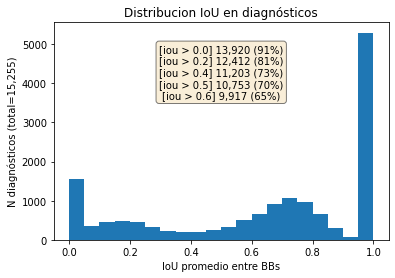

In [193]:
_ = plot_disagreement(thresh=(0, 0.2, 0.4, 0.5, 0.6))

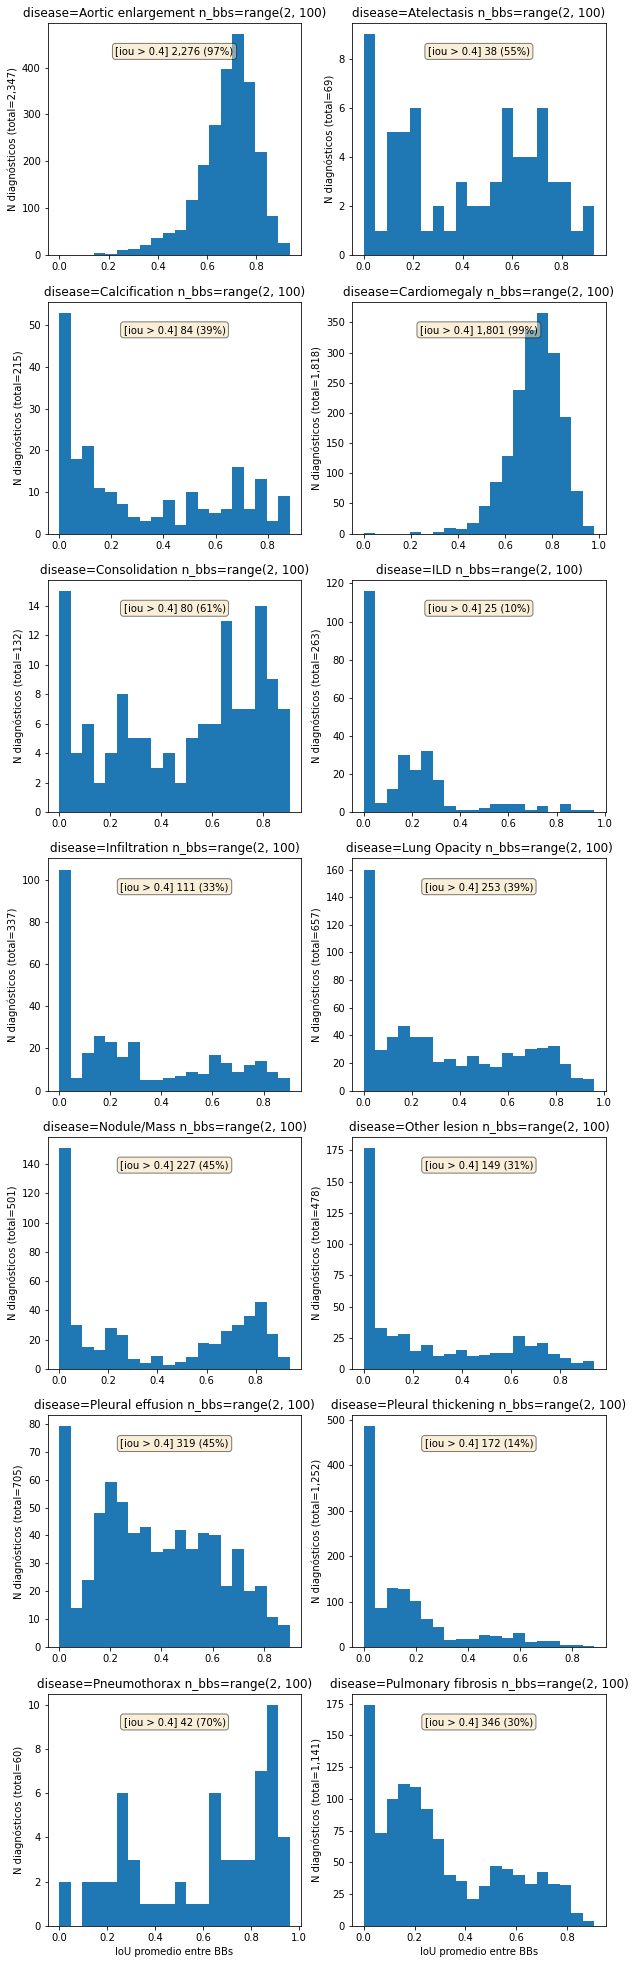

In [192]:
n_rows = 7
n_cols = 2
plt.figure(figsize=(n_cols*5, n_rows*5))

for disease in range(0, 14):
    plt.subplot(n_rows, n_cols, disease+1)
    plot_disagreement(disease=disease, n_bbs=range(2, 100))
    if disease // n_cols + 1 != n_rows:
        plt.xlabel('')

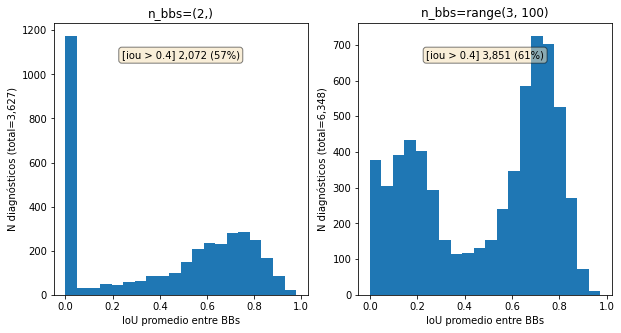

In [189]:
n_rows = 1
n_cols = 2
plt.figure(figsize=(n_cols*5, n_rows*5))

plt.subplot(n_rows, n_cols, 1)
plot_disagreement(n_bbs=2)

plt.subplot(n_rows, n_cols, 2)
_ = plot_disagreement(n_bbs=range(3, 100))

## Create master JSON

In [194]:
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


### Labels df

In [234]:
import torch
import numpy as np
from ignite.utils import to_onehot

In [208]:
diseases_by_image = df.groupby('image_id')['class_id'].apply(set)
diseases_by_image

image_id
000434271f63a053c4128a0ba6352c7f                 {14}
00053190460d56c53cc3e57321387478                 {14}
0005e8e3701dfb1dd93d53e2ff537b6e         {8, 4, 6, 7}
0006e0a85696f6bb578e84fafa9a5607                 {14}
0007d316f756b3fa0baea2ff514ce945    {0, 3, 5, 11, 13}
                                          ...        
ffe6f9fe648a7ec29a50feb92d6c15a4            {0, 9, 3}
ffea246f04196af602c7dc123e5e48fc                 {14}
ffeffc54594debf3716d6fcd2402a99f                  {0}
fff0f82159f9083f3dd1f8967fc54f6a                 {14}
fff2025e3c1d6970a8a6ee0404ac6940                 {14}
Name: class_id, Length: 15000, dtype: object

In [250]:
diseases_by_image['00053190460d56c53cc3e57321387478']

{14}

In [235]:
images = list(diseases_by_image.index)
labels = torch.stack([
    to_onehot(torch.tensor(list(diseases)), len(VINBIG_DISEASES)).sum(dim=0)
    for diseases in diseases_by_image
], dim=0)
labels = np.array(labels)
len(images), len(diseases_by_image), labels.shape

(15000, 15000, (15000, 15))

In [241]:
labels_df = pd.DataFrame(labels, columns=VINBIG_DISEASES)
labels_df['image_id'] = images
labels_df.head()

,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No finding,image_id
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,000434271f63a053c4128a0ba6352c7f
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,00053190460d56c53cc3e57321387478
2,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0005e8e3701dfb1dd93d53e2ff537b6e
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0006e0a85696f6bb578e84fafa9a5607
4,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0007d316f756b3fa0baea2ff514ce945


In [254]:
# sanity checks
diseases = list(VINBIG_DISEASES)
diseases.remove('No finding')

errors = defaultdict(list)

for index, row in labels_df.iterrows():
    image_id = row['image_id']
    if row['No finding'] == 1:
        if not row[diseases].to_numpy().sum() == 0:
            errors['no-finding-vs-diseases'].append(image_id)
    
    should_have_diseases = diseases_by_image[image_id]
    has_diseases = set([
        index
        for index, value in enumerate(row[VINBIG_DISEASES])
        if value == 1
    ])
    if set(should_have_diseases) != set(has_diseases):
        errors['diseases-wrong'].append(image_id)
        
{(k, len(v)) for k, v in errors.items()}

set()

In [257]:
cols = ['image_id'] + VINBIG_DISEASES[:-1]
labels_df = labels_df[cols]
labels_df.head()

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis
0,000434271f63a053c4128a0ba6352c7f,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00053190460d56c53cc3e57321387478,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0005e8e3701dfb1dd93d53e2ff537b6e,0,0,0,0,1,0,1,1,1,0,0,0,0,0
3,0006e0a85696f6bb578e84fafa9a5607,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0007d316f756b3fa0baea2ff514ce945,1,0,0,1,0,1,0,0,0,0,0,1,0,1


In [258]:
fpath = os.path.join(DATASET_DIR, 'labels.csv')
labels_df.to_csv(fpath, index=False)

### BBs dict

In [270]:
import json

In [380]:
%%time

master_dict = defaultdict(list)
keys = ['x_min', 'y_min', 'x_max', 'y_max']

for index, row in df.iterrows():
    image_id = row['image_id']
    class_id = row['class_id']
    
    if class_id == 14:
        continue
    
    x_min, y_min, x_max, y_max = row[keys].to_numpy().astype(int).tolist()
    master_dict[image_id].append((class_id, x_min, y_min, x_max, y_max))

CPU times: user 18.5 s, sys: 37.3 ms, total: 18.5 s
Wall time: 18.6 s


In [381]:
len(master_dict)

4394

In [382]:
fpath = os.path.join(DATASET_DIR, 'bboxes.json')
with open(fpath, 'w') as f:
    json.dump(master_dict, f)

# Calculate mean and std

In [273]:
%run ../../utils/images.py

In [275]:
images_dir = os.path.join(DATASET_DIR, 'images')
images = os.listdir(images_dir)
len(images)

15000

In [276]:
compute_mean_std(ImageFolderIterator(images_dir, images), show=True)

  0%|          | 0/15000 [00:00<?, ?it/s]

(tensor([0.5489, 0.5489, 0.5489]), tensor([0.2498, 0.2498, 0.2498]))

# Split dataset

train and validation only

## Make split

In [277]:
import random

In [278]:
SPLITS_DIR = os.path.join(DATASET_DIR, 'splits')

def save_split(items, name):
    filepath = os.path.join(SPLITS_DIR, f'{name}.txt')
    with open(filepath, 'w') as f:
        for item in items:
            f.write(f'{item}\n')

    print(f'List saved to: {filepath}')

In [279]:
images = os.listdir(os.path.join(DATASET_DIR, 'images'))

In [280]:
VAL_SPLIT = 0.1

In [281]:
val_images = random.sample(images, int(VAL_SPLIT * len(images)))
train_images = list(set(images) - set(val_images))
len(train_images), len(val_images)

(13500, 1500)

## Check split distribution

In [318]:
DISEASES = VINBIG_DISEASES[:-1]

def plot_distribution(images, **kwargs):
    d = labels_df
    
    images = [
        i.replace('.png', '')
        for i in images
    ]
    
    d = d.loc[d['image_id'].isin(set(images))]
    values = d[DISEASES].sum(axis=0)
    
    plt.bar(DISEASES, values, **kwargs)
    plt.xticks(rotation=90)

No handles with labels found to put in legend.


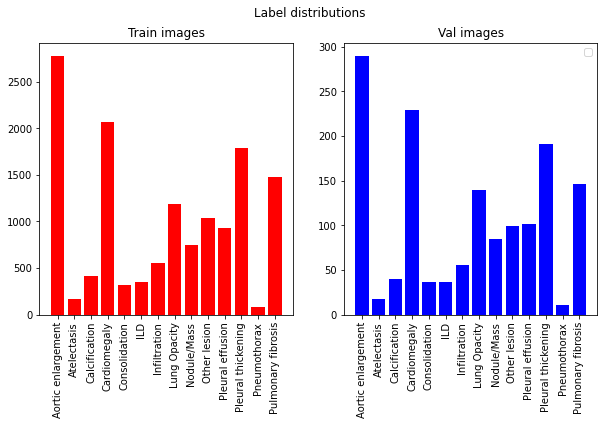

In [319]:
plt.figure(figsize=(10, 5))

plt.suptitle('Label distributions')

plt.subplot(1, 2, 1)
plt.title('Train images')
plot_distribution(train_images, color='red')

plt.subplot(1, 2, 2)
plt.title('Val images')
plot_distribution(val_images, color='blue')

plt.legend()

## Save split to disk

In [ ]:
save_split(train_images, 'train')
save_split(val_images, 'val')

In [ ]:
save_split(train_images + val_images, 'all')

# Debug dataset class

In [455]:
%run ../vinbig.py

In [456]:
dataset = VinBigDataset('all', masks=True)
len(dataset)

15000

In [457]:
item = dataset[9077]
item.image.size(), item.labels.shape

(torch.Size([3, 512, 512]), (14,))

In [458]:
item.masks.size()

torch.Size([14, 512, 512])

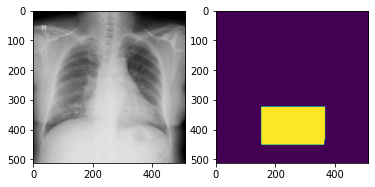

In [459]:
plt.subplot(1, 2, 1)
plt.imshow(tensor_to_range01(item.image).permute(1, 2, 0))

plt.subplot(1, 2, 2)
plt.imshow(item.masks[3])